In [1]:
import numpy as np 
import matplotlib.pyplot as plt

from games_learning.game.matrix_game import MatrixGame

We introduce the three main concepts and classes:
- Matrix Games
- Strategies
- Learning Algorithms

## Matrix Games

The basic structure we use are matrix games. Matrix games can be simply defined by defining a payoff-matrix (e.g. battle of sexes) or constructed through discretization from some continuous game (e.g., auctions).

In [2]:
payoff_matrix = np.array([
        [[1, -2, 3], [3, -1, 2], [2, 1, 3]],   
        [[-1, 2, 1], [-3, 4, 2], [3, 1, 3]]
     ])
game = MatrixGame(payoff_matrix=payoff_matrix, name="example")
game

MatrixGame(example,[3, 3])

You can access basic properties such as number of agents, number of actions, and the payoff matrix:

In [3]:
print("Number of Agents:", game.n_agents)
print("Number of Actions:", game.n_actions)
print("Payoff Matrices:\n", game.payoff_matrix)

Number of Agents: 2
Number of Actions: [3, 3]
Payoff Matrices:
 [[[ 1 -2  3]
  [ 3 -1  2]
  [ 2  1  3]]

 [[-1  2  1]
  [-3  4  2]
  [ 3  1  3]]]


There are different methods to analyze games:

In [4]:
# We can compute all pure Nash equilibria
# note that ne = weak_ne + strict_ne
game.get_pne()

{'weak_ne': [(2, 2)], 'strict_ne': [], 'ne': [(2, 2)]}

In [5]:
# If we provide a list of names for the actions, the ouput gives us the names instead of the numbers
game = MatrixGame(payoff_matrix=payoff_matrix, name="example", name_actions=[["A", "B", "C"], ["D", "E", "F"]])
pne = game.get_pne()
game.get_named_actions(pne)

{'weak_ne': [('C', 'F')], 'strict_ne': [], 'ne': [('C', 'F')]}

In [6]:
# We compute correlated and coarse correlated equilibria 
print("CCE: \n", game.get_cce())
print("CE:\n", game.get_ce())

CCE: 
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]
CE:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


In [7]:
# If wou want to check, if other actions can be supported by a (C)CE, you can either define a respective objective
c = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
print("CE:\n", game.get_ce(objective=c))
print("CCE:\n", game.get_cce(objective=c))

CE:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]
CCE:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


In [8]:
# Or you can call a function to compute the support of all possible CCEs 
# (note that this corresponds to #actions ^ #agents computations of CCE)
game.get_supp_cce()

array([[False, False,  True],
       [False, False, False],
       [ True, False,  True]])

In [9]:
# we can also determine actions that are serially undominated (su)
# note: if you are interested in the reduced game, use the method in games.learning/utils/dominance.py 
su_actions = game.get_undominated_actions(dominance="strict", print=True)
su_actions

(3, 3) --> (3, 3)
Actions Agent 0: 0 1 2
Actions Agent 1: 0 1 2


{0: [0, 1, 2], 1: [0, 1, 2]}

#### Other Games

Other ways to create matrix game are given by the following classes:
- *ExampleMatrixGames*: classical examples such as matching_pennis, prisoners_dilemma, ...
- *RandomMatrixGames*: sample entries of payoff matrix
- *EconGames*: discretized version of complete-information economic games, e.g., auctions, contests, oligopolies

In [10]:
from games_learning.game.matrix_game import ExampleMatrixGames
from games_learning.game.econ_game import FPSB, AllPay

In [11]:
# Example: Prisoners' Dilemma
game1 = ExampleMatrixGames(setting="prisoners_dilemma")
game1.get_supp_cce()

array([[False, False],
       [False,  True]])

In [12]:
# Example First-Price Sealed-Bid Auction
game2 = FPSB(n_agents=2, n_discr=19, valuations=(1.0, 1.0), interval=(0.05, 0.95))
print("pure NE (numbered):", game2.get_pne())
print("pure NE (named)   :", game2.get_named_actions(game2.get_pne()))
print("\nSerially strict undominated actions:")
undom_actions = game2.get_undominated_actions(dominance="strict", print=True)

pure NE (numbered): {'weak_ne': [(17, 17)], 'strict_ne': [(18, 18)], 'ne': [(18, 18), (17, 17)]}
pure NE (named)   : {'weak_ne': [('0.90', '0.90')], 'strict_ne': [('0.95', '0.95')], 'ne': [('0.95', '0.95'), ('0.90', '0.90')]}

Serially strict undominated actions:
(19, 19) --> (2, 2)
Actions Agent 0: X X X X X X X X X X X X X X X X X 17 18
Actions Agent 1: X X X X X X X X X X X X X X X X X 17 18


In [13]:
game3 = AllPay(n_agents=2, n_discr=7, valuations=(1.0, 1.0), interval=(0.05, 0.95))
print("pure NE:", game3.get_pne()["ne"])
print("\nSerially strict undominated actions:")
undom_actions = game3.get_undominated_actions(dominance="strict", print=True)
game3.get_named_actions(undom_actions)

pure NE: []

Serially strict undominated actions:
(7, 7) --> (7, 7)
Actions Agent 0: 0 1 2 3 4 5 6
Actions Agent 1: 0 1 2 3 4 5 6


{0: ['0.05', '0.20', '0.35', '0.50', '0.65', '0.80', '0.95'],
 1: ['0.05', '0.20', '0.35', '0.50', '0.65', '0.80', '0.95']}

## Strategies

Especially in the context of learning algorithms, we look at the mixed extension of the game, i.e., we consider the action set of mixed strategies. These allow us to compute the expected utility, gradient, etc. for any mixed strategy profile

In [14]:
from games_learning.strategy import Strategy

In [15]:
s = Strategy(game, init_method = "equal")
print("Strategies:", s)
print("Current values of s:\n", s.x)

Strategies: Strategies(game:example, [3, 3])
Current values of s:
 [array([0.33333333, 0.33333333, 0.33333333]), array([0.33333333, 0.33333333, 0.33333333])]


In [16]:
# Given the mixed strategy, we can compute the gradient for an agent
grad0 = s.gradient(agent=0)
print("Gradient Agent 0:", grad0)

Gradient Agent 0: [0.66666667 1.33333333 2.        ]


In [17]:
# a fast way to access the current gradient for all agents is
s.y

[array([0.66666667, 1.33333333, 2.        ]),
 array([-0.33333333,  2.33333333,  2.        ])]

In [18]:
# given the gradient we can compute the expected utility, best response and utility loss of an agent:
exp_util = s.utility(agent=0)
abs_util_los = s.utility_loss(agent=0, method="abs")
print(f"Expected Utility     : {exp_util:.3f}")
print(f"Absolute Utility Loss: {abs_util_los:.3f}")

Expected Utility     : 1.333
Absolute Utility Loss: 0.667


In [19]:
s.best_response(agent=0)

array([0., 0., 1.])

In [20]:
# Note that the computation of the utility, best response, and utility loss, all require the gradient. 
# To speed up the computation, you can reuse the already computed gradient:
%timeit exp_util = s.utility(agent=0)
%timeit exp_util = s.utility(agent=0, gradient=grad0)

29.8 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.07 µs ± 156 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


# Learner

The learner class provides us with a (gradient-based) method to update strategies:

In [21]:
from games_learning.learner.mirror_ascent import MirrorAscent

In [22]:
learner = MirrorAscent(eta=2, beta=0.05, mirror_map="entropic")
gradients = s.y 
x_new = learner.update(s, gradients, iter=1)

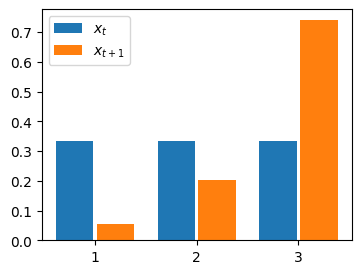

In [23]:
plt.figure(figsize=(4,3))
plt.bar(np.arange(3)-0.2, s.x[0], width=0.37, label="$x_t$")
plt.bar(np.arange(3)+0.2, x_new[0], width=0.37, label="$x_{t+1}$")
plt.xticks(range(3), range(1, 4))
plt.legend()
plt.show()

## Simulation

To run simulations where agents (simultaneously or sequentially) update their strategy using some learning algorithm, we can use the simulator class:

In [24]:
from games_learning.simulation import Simulator

In [25]:
game = ExampleMatrixGames(setting="rock_paper_scissors")
strategy = Strategy(game, init_method="uniform_sym")
learner = MirrorAscent(eta=0.06, beta=0.0, mirror_map="entropic")
sim = Simulator(strategy, learner, max_iter=1_000)
sim.run()

{'game': 'rock_paper_scissors',
 'learner': 'mirror_ascent(entropic)',
 'convergence': False,
 'iterations': 1000,
 'utility_loss': 1.0,
 'min_utility_loss': 0.9999999999999999}

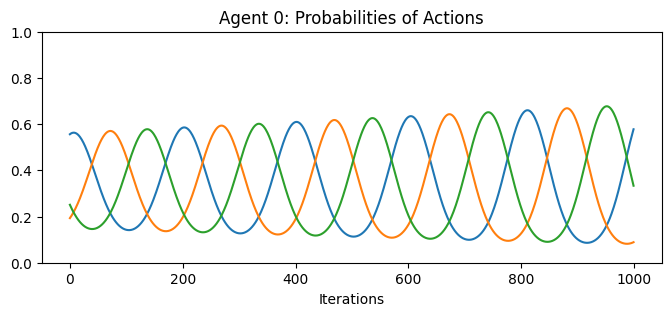

In [26]:
agent = 1
plt.figure(figsize=(8,3))
for a in range(strategy.n_actions[agent]):
    plt.plot([sim.log_data["strategies"][agent][t][a] for t in range(1_000)])

plt.xlabel("Iterations"); plt.ylim(0,1)
plt.title("Agent 0: Probabilities of Actions")
plt.show()